# Model-Based Reinforcement Learning: the General Idea
We consider the optimal control problem of an MDP with a *known* reward function $R$ and subject to *unknown deterministic* dynamics $s_{t+1} = f(s_t, a_t)$:
$$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In *model-based* reinforcement learning, this problem is split into two subtasks:
1. Model learning

We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. Planning

We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

# Warming up
We start with a few useful imports.

In [63]:
# Environment
import gym
import highway_env

# Modelling
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt


# Experience collection
First, we randomly interact with the environment to produce a batch of experiences 
$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [64]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000):
    data, done = [], True
    for _ in range(size):
        previous_obs = env.reset() if done else obs
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        data.append(Transition(torch.Tensor(previous_obs["observation"]),
                               torch.Tensor(action),
                               torch.Tensor(obs["observation"])))
    return data


env = gym.make("parking-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000, -0.0000, -0.0084, -0.0054]), action=tensor([-0.5059,  0.6038]), next_state=tensor([ 0.0102,  0.0059,  0.0227,  0.0111, -0.0090, -0.0044]))


# Build dynamics model

We choose to represent the dynamics using a structured model inspired from *LTI models* (Linear Time-Invariant):
$$x_{t+1} = f_\theta(x_t, u_t) = A_\theta(x_t, u_t)x_t + B_\theta(x_t, u_t)u_t$$

That is, we learn at each point $(x_t, u_t)$ the linearization of the true dynamics model $f_\theta$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with a single hidden layer.


In [65]:
class DynamicsModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super().__init__()
        self.state_size, self.action_size = state_size, action_size
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u, dt=1.0):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            u = u.unsqueeze(0)
        xu = torch.cat((x, u), -1)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze() * dt


dynamics = DynamicsModel(env.observation_space.spaces["observation"].shape[0],
                         env.action_space.shape[0],
                         10)
print("Forward model on sample transition:", dynamics(data[0].state, data[0].action))

Forward model on sample transition: tensor([[ 0.0391, -0.2370,  0.0959, -0.0775, -0.2110,  0.1991]],
       grad_fn=<AddBackward0>)


# Training helpers
We define some simple functions to handle the dataset, define the loss, and visualize the predictions.

In [66]:
def transpose_batch(data):
    zipped = Transition(*zip(*data))
    states = torch.stack(zipped.state)
    actions = torch.stack(zipped.action)
    next_states = torch.stack(zipped.next_state)
    return states, actions, next_states

def compute_loss(model, data_t):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    loss_func = torch.nn.MSELoss()
    return loss_func(predictions, next_states), predictions

def visualize(data_t, predictions):
    plt.cla()
    states, actions, next_states = data_t
    delta_x = next_states.data.numpy() - states.data.numpy()
    pred_delta_x = predictions.data.numpy() - states.data.numpy()
    actions = actions.data.numpy()
    plt.scatter(actions[:, 0], delta_x[:, 2], label="true")
    plt.scatter(actions[:, 0], pred_delta_x[:, 2], label="predicted")
    plt.xlabel("acceleration")
    plt.ylabel("vx variation")
    plt.pause(0.1)

# Fit model on data
We can now train the model to minimize an MSE loss over our experience batch $D$:

$$\min_\theta \sum_{s_t,a_t,s_{t+1}\in D}L^2(s_{t+1}- f_\theta(s_t, a_t))$$

[1/500] Training loss: 5.953E-02, validation loss: 2.340E-02
[100/500] Training loss: 1.066E-03, validation loss: 1.391E-03
[200/500] Training loss: 8.589E-04, validation loss: 1.253E-03
[300/500] Training loss: 7.014E-04, validation loss: 1.298E-03
[400/500] Training loss: 5.660E-04, validation loss: 1.333E-03
[500/500] Training loss: 4.917E-04, validation loss: 1.295E-03


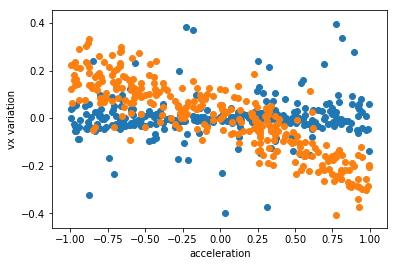

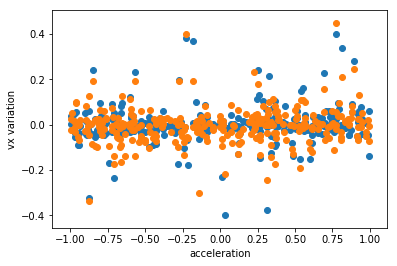

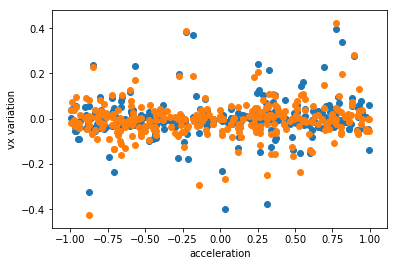

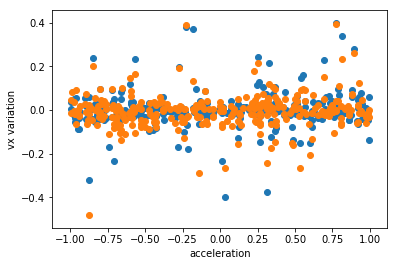

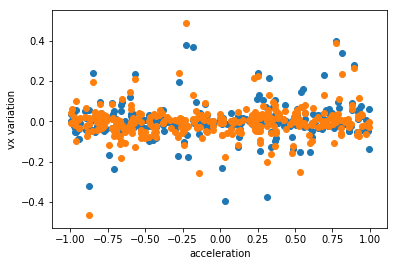

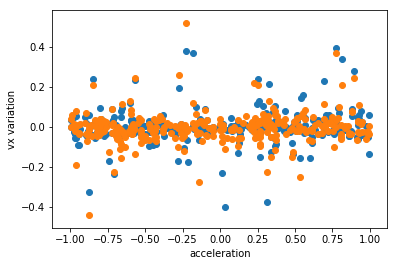

In [67]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.05)

# Split dataset into training and validation
train_ratio = 0.7
data, validation_data = data[:int(train_ratio * len(data))], \
                        data[int(train_ratio * len(data)):]

def train(model, data, validation_data, epochs=500):
    data_t = transpose_batch(data)
    validation_data_t = transpose_batch(validation_data)
    for epoch in range(epochs):
        loss, _ = compute_loss(model, data_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Monitor training
        if (epoch + 1) % (epochs // 5) == 0 or epoch == 0:
            # Compute validation loss
            validation_loss, predictions = compute_loss(model, validation_data_t)
            print("[{}/{}] Training loss: {:.3E}, validation loss: {:.3E}".format(
                epoch+1, epochs, loss.data.numpy(), validation_loss.detach().data.numpy()))
            visualize(validation_data_t, predictions)
        plt.ioff()
        plt.show()

train(dynamics, data, validation_data)

# Leverage model for planning

